In [177]:
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import scipy.optimize as optimize
from sklearn.metrics import r2_score
import math
import scipy.stats as stats


In [165]:
plt.style.use("default")
plt.rcParams.update({'font.size': 22})

# Test MA selection hypothesis

Does the SureChemBL patent MA results suggest that there is selection for higher-MA compounds?

## Testing

1. Build a scatter plot for a specific MA value (start at 15 because why not) 
- Xaxis: months (starting at Feb 1976)
- Yaxis: log(change in MA=15 values between month & month - 1)

2. Calculate alpha (linear/exponential fit?) for MA=15 scatter plot

3. Extend to other MA values (16-20)

4. Plot MA (xaxis) x alpha (yaxis) plot

5. Extend to all reasonable MA values (5 - 45?)


In [166]:
MA_df = pd.read_csv("Data/AssemblyValues/ALLSAMPLEDcpds_AssemblyGo_COMPLETED.csv")

MA_df.head()

,Unnamed: 0,Unnamed: 0.1,label,MA_assemblyGo,time,earliest_date,date_ordinal
0,3,3,SCHEMBL10000078,10.0,28.798358,2010-03-25,733856
1,4,4,SCHEMBL10000080,6.0,0.351274,2010-03-25,733856
2,12,12,SCHEMBL10000225,8.0,0.005756,2011-10-13,734423
3,13,13,SCHEMBL10000246,8.0,1.418643,2007-03-08,732743
4,14,14,SCHEMBL10000283,6.0,0.718971,2010-01-21,733793


In [167]:
#Find month of each compound - essentially, just remove the last three characters from earliest_date

def get_month(date):
    return date[:-3]

MA_df["month"] = MA_df["earliest_date"].apply(get_month)

In [168]:
print(MA_df)

         Unnamed: 0  Unnamed: 0.1             label  MA_assemblyGo  \
0                 3             3   SCHEMBL10000078           10.0   
1                 4             4   SCHEMBL10000080            6.0   
2                12            12   SCHEMBL10000225            8.0   
3                13            13   SCHEMBL10000246            8.0   
4                14            14   SCHEMBL10000283            6.0   
...             ...           ...               ...            ...   
1529437     3808331       3826690   2022-12_97_full            9.0   
1529438     3808335       3826694  2022-12_973_full           12.0   
1529439     3808342       3826701   2022-12_98_full           11.0   
1529440     3808349       3826708  2022-12_988_full           21.0   
1529441     3808356       3826715  2022-12_994_full           11.0   

               time earliest_date  date_ordinal    month  
0         28.798358    2010-03-25        733856  2010-03  
1          0.351274    2010-03-25        

In [169]:
MA15_df = MA_df[MA_df["MA_assemblyGo"] == 15]

print(MA15_df)

         Unnamed: 0  Unnamed: 0.1             label  MA_assemblyGo  \
40               85            86    SCHEMBL1000181           15.0   
42               87            88   SCHEMBL10001887           15.0   
143             314           318    SCHEMBL1000941           15.0   
271             555           562   SCHEMBL10015743           15.0   
275             569           576   SCHEMBL10015757           15.0   
...             ...           ...               ...            ...   
1529384     3808172       3826531  2022-12_824_full           15.0   
1529389     3808193       3826552  2022-12_844_full           15.0   
1529393     3808204       3826563  2022-12_854_full           15.0   
1529416     3808270       3826629  2022-12_913_full           15.0   
1529432     3808315       3826674  2022-12_955_full           15.0   

               time earliest_date  date_ordinal    month  
40         1.325993    2005-01-06        731952  2005-01  
42       121.005073    2007-02-08        

In [155]:
MA15_df = MA15_df[MA15_df["month"] < "2020"]
print(MA15_df)

         Unnamed: 0  Unnamed: 0.1                label  MA_assemblyGo  \
40               85            86       SCHEMBL1000181           15.0   
42               87            88      SCHEMBL10001887           15.0   
143             314           318       SCHEMBL1000941           15.0   
271             555           562      SCHEMBL10015743           15.0   
275             569           576      SCHEMBL10015757           15.0   
...             ...           ...                  ...            ...   
1513814     3772650       3791009  2019-12_116975_full           15.0   
1513851     3772761       3791120  2019-12_117087_full           15.0   
1513880     3772845       3791204  2019-12_117172_full           15.0   
1513890     3772904       3791263  2019-12_117232_full           15.0   
1513908     3772959       3791318  2019-12_117287_full           15.0   

               time earliest_date  date_ordinal    month  
40         1.325993    2005-01-06        731952  2005-01  
42   

In [170]:
#Find the number of MA 15 values per month
MA15_counts_df = MA15_df.month.value_counts().reset_index(name="MA 15 Sum")

In [171]:
MA15_counts_df = MA15_counts_df.sort_values(by=["index"])

In [172]:
print(MA15_counts_df)

       index  MA 15 Sum
573  1973-04          1
565  1973-05          3
566  1973-10          2
571  1973-11          1
572  1974-05          1
..       ...        ...
557  2022-08         21
550  2022-09         24
554  2022-10         21
563  2022-11         12
548  2022-12         25

[575 rows x 2 columns]


In [173]:
MA15_counts_df["cumulative_sum"] = MA15_counts_df["MA 15 Sum"].cumsum()

print(MA15_counts_df)

       index  MA 15 Sum  cumulative_sum
573  1973-04          1               1
565  1973-05          3               4
566  1973-10          2               6
571  1973-11          1               7
572  1974-05          1               8
..       ...        ...             ...
557  2022-08         21           55953
550  2022-09         24           55977
554  2022-10         21           55998
563  2022-11         12           56010
548  2022-12         25           56035

[575 rows x 3 columns]


In [175]:
MA15_counts_df["deltaMA"] = MA15_counts_df['cumulative_sum'] - MA15_counts_df['cumulative_sum'].shift(1)

MA15_counts_df["logDeltaMA"] = np.log(MA15_counts_df["deltaMA"])
MA15_counts_df["logCumSum"] = np.log(MA15_counts_df["cumulative_sum"])

MA15_counts_df = MA15_counts_df.dropna()
print(MA15_counts_df)

       index  MA 15 Sum  cumulative_sum  deltaMA  logDeltaMA  logCumSum
566  1973-10          2               6      2.0    0.693147   1.791759
571  1973-11          1               7      1.0    0.000000   1.945910
572  1974-05          1               8      1.0    0.000000   2.079442
568  1974-07          1               9      1.0    0.000000   2.197225
567  1974-09          1              10      1.0    0.000000   2.302585
..       ...        ...             ...      ...         ...        ...
557  2022-08         21           55953     21.0    3.044522  10.932267
550  2022-09         24           55977     24.0    3.178054  10.932696
554  2022-10         21           55998     21.0    3.044522  10.933071
563  2022-11         12           56010     12.0    2.484907  10.933286
548  2022-12         25           56035     25.0    3.218876  10.933732

[573 rows x 6 columns]


In [ ]:
## Calculate alpha
np.polyfit(numpy.log(x), y, 1)

In [161]:
## Attempt to fit alpha (I think this is the right way?)
scipy_fit = optimize.curve_fit(lambda t,a,b: a+b*t, MA15_counts_df["cumulative_sum"],  MA15_counts_df["logDeltaMA"], p0=(5, 0.00001))[0]
print(scipy_fit)

scipy_r2 = r2_score(MA15_counts_df["logDeltaMA"], scipy_fit[0] + MA15_counts_df["cumulative_sum"]*scipy_fit[1])
print(scipy_r2)


[3.90132011e+00 2.43123546e-05]
0.27898428937317776


In [162]:
np_fit = np.polyfit(MA15_counts_df["cumulative_sum"], np.log(MA15_counts_df["deltaMA"]), 1, w=np.sqrt(MA15_counts_df["deltaMA"]))
print(np_fit)

np_r2 = r2_score(MA15_counts_df["logDeltaMA"], np_fit[1] + MA15_counts_df["cumulative_sum"]*np_fit[0])
print(np_r2)

[2.08426194e-05 4.19702265e+00]
0.1895557822718814


In [181]:
#Attempt #3 for alpha - linear regression over log/log data

stats_fit = stats.linregress(MA15_counts_df["logCumSum"], MA15_counts_df["logDeltaMA"])
print(stats_fit)
print(stats_fit[0])


LinregressResult(slope=0.33797782647532926, intercept=1.1586526606625926, rvalue=0.65309390641976, pvalue=5.779523868108614e-71, stderr=0.016400203979069473, intercept_stderr=0.15807139806603726)
0.33797782647532926


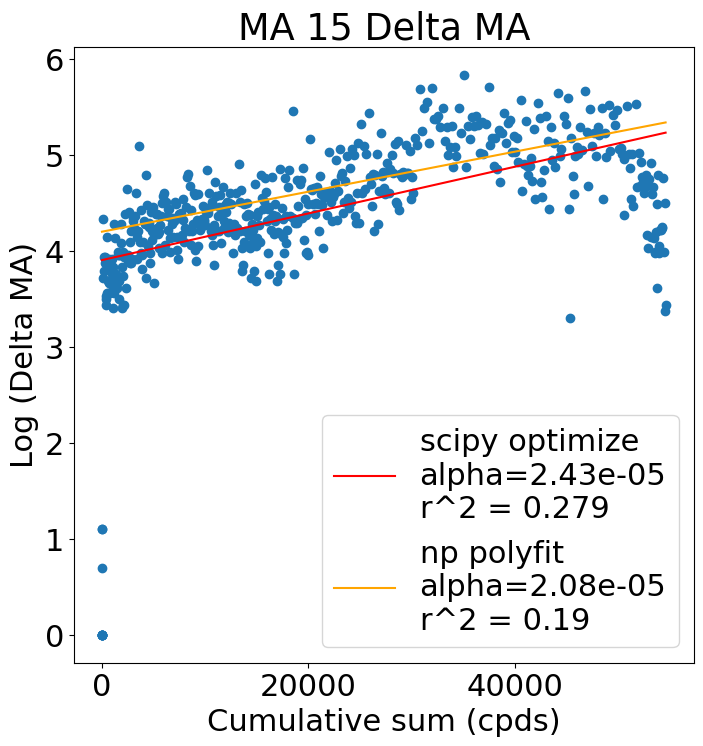

In [163]:
plt.figure(figsize=(8,8))

plt.scatter(MA15_counts_df["cumulative_sum"], MA15_counts_df["logDeltaMA"])

plt.plot(MA15_counts_df["cumulative_sum"], scipy_fit[0] + MA15_counts_df["cumulative_sum"]*scipy_fit[1], 
    color="red", label=f"scipy optimize\nalpha={round(scipy_fit[1],7)}\nr^2 = {round(scipy_r2,3)}")

plt.plot(MA15_counts_df["cumulative_sum"], np_fit[1] + MA15_counts_df["cumulative_sum"]*np_fit[0], 
    color="orange", label=f"np polyfit\nalpha={round(np_fit[0],7)}\nr^2 = {round(np_r2,3)}")


plt.xlabel("Cumulative sum (cpds)")
plt.ylabel("Log (Delta MA)")
plt.title("MA 15 Delta MA")
plt.legend()

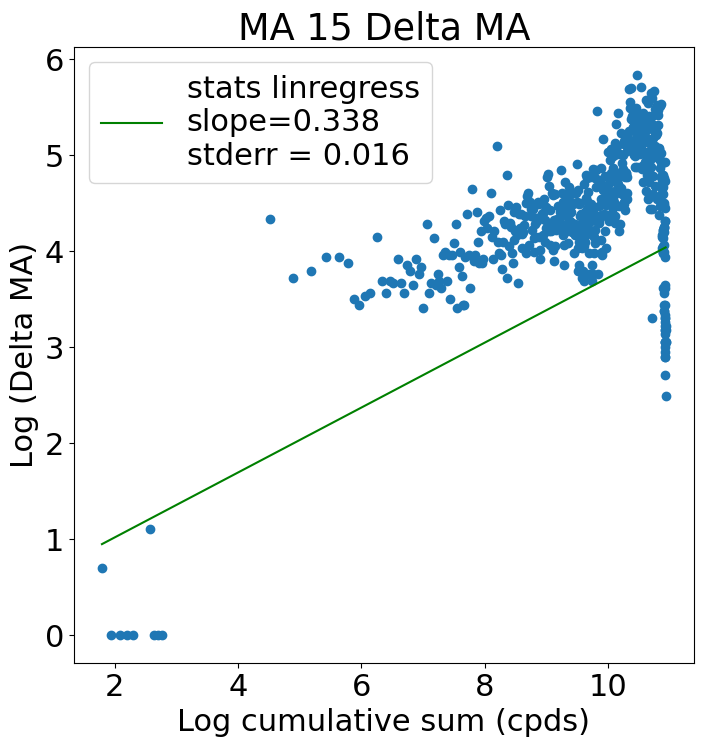

In [182]:
plt.figure(figsize=(8,8))

plt.scatter(MA15_counts_df["logCumSum"], MA15_counts_df["logDeltaMA"])

plt.plot(MA15_counts_df["logCumSum"], stats_fit[0] + MA15_counts_df["logCumSum"]*stats_fit[0], 
    color="green", label=f"stats linregress\nslope={round(stats_fit[0],3)}\nstderr = {round(stats_fit[4],3)}")



plt.xlabel("Log cumulative sum (cpds)")
plt.ylabel("Log (Delta MA)")
plt.title("MA 15 Delta MA")
plt.legend()

In [62]:
print(4.04975441 + np.exp(MA15_counts_df["cumulative_sum"]*1.34622178e-05))

565    5.049808
566    5.049835
571    5.049849
572    5.049862
568    5.049876
         ...   
557    6.173649
550    6.174335
554    6.174936
563    6.175279
548    6.175995
Name: cumulative_sum, Length: 574, dtype: float64


Text(0.5, 1.0, 'MA 15 Delta MA')

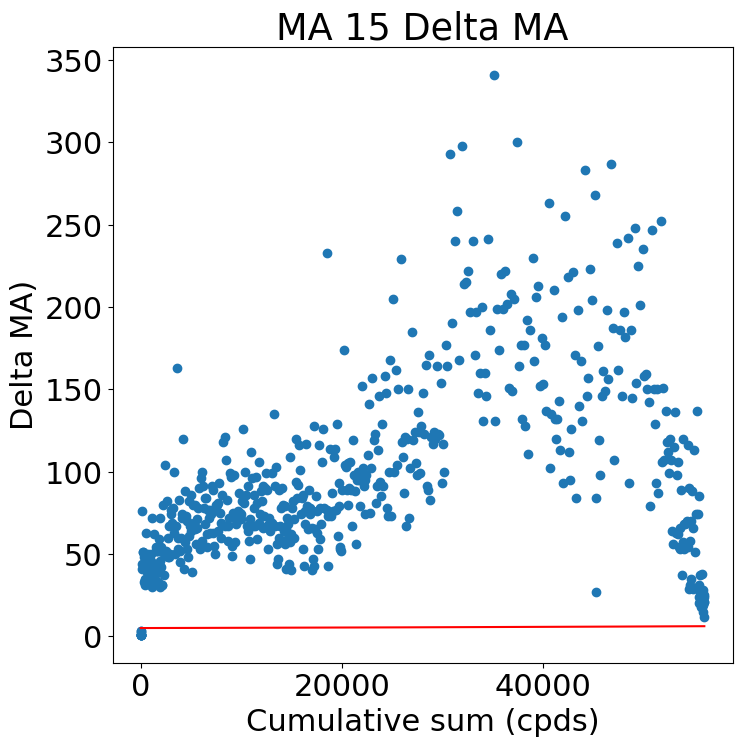

In [61]:
plt.figure(figsize=(8,8))

plt.scatter(MA15_counts_df["cumulative_sum"], MA15_counts_df["deltaMA"])

plt.xlabel("Cumulative sum (cpds)")
plt.ylabel("Delta MA)")
plt.title("MA 15 Delta MA")

## Automated version

Over a range of MA values (3-40, arbitrarily), find alpha from np.polyfit, and graph this over MA values

In [186]:
def get_specific_MA_df(MA_df, value):
    return MA_df[MA_df["MA_assemblyGo"] == value]

def get_alpha(sub_df):
    np_fit = np.polyfit(sub_df["cumulative_sum"], np.log(sub_df["deltaMA"]), 1, w=np.sqrt(sub_df["deltaMA"]))
    return np_fit[0]

def get_loglog_slope(sub_df):
    stats_fit = stats.linregress(sub_df["logCumSum"], sub_df["logDeltaMA"])
    return stats_fit[0]

In [188]:
alphas = []
loglog_slopes = []
sizes = []

for MA_value in tqdm(range(3,41)):
    #Subset MA results by MA value
    sub_df = get_specific_MA_df(MA_df, MA_value)
    sizes.append({MA_value:len(sub_df)})

    #Count number of occurances of MA values within each month & sort dataframe
    sub_df = sub_df.month.value_counts().reset_index(name="MA_Sum")
    sub_df = sub_df.sort_values(by=["index"])

    #Count cumulative number of MA values
    sub_df["cumulative_sum"] = sub_df["MA_Sum"].cumsum()

    #Calculate changes in MA (including log), drop na values
    sub_df["deltaMA"] = sub_df['cumulative_sum'] - sub_df['cumulative_sum'].shift(1)
    sub_df["logDeltaMA"] = np.log(sub_df["deltaMA"])
    sub_df["logCumSum"] = np.log(sub_df["cumulative_sum"])

    sub_df = sub_df.dropna()

    alphas.append(get_alpha(sub_df))
    loglog_slopes.append(get_loglog_slope(sub_df))
    
    

100%|██████████| 38/38 [00:00<00:00, 40.46it/s]


In [145]:
print(alphas)

[-0.001273682818348098, -0.000142766604228945, -2.8962418484086036e-05, -1.044500833789973e-05, -4.5007454107885e-06, -1.7686880502373206e-06, 1.8334993983896525e-07, 1.959497140288011e-06, 3.5351920285563807e-06, 5.623426928835151e-06, 7.963986461071653e-06, 1.1137590230736575e-05, 1.6963181171405867e-05, 2.6107362732134584e-05, 3.886222813739825e-05, 6.047460715552514e-05, 8.510430849981507e-05, 0.00010797745470857467, 0.00012073653661679731, 0.00013060311834684184, 0.00013614225142582237, 0.00013701100613823527, 0.00014963205364222176, 0.00016904584183798852, 0.00020145601815199453, 0.00026527037523067706, 0.0003038376569378938, 0.00036804896095812714, 0.00048650697380921566, 0.00048474356103183643, 0.0006769280922218836, 0.0008016694539040406, 0.001119535421656655, 0.0012762331568570246, 0.0015060530602911855, 0.001986026914909884, 0.0026388427002926374, 0.0037823792233410863]


In [189]:
print(loglog_slopes)

[-0.17630655355460928, 0.04919413962628729, 0.21905991122283036, 0.2864176359980058, 0.3376879229447285, 0.37376537312985325, 0.39361908534263484, 0.45255551478929423, 0.46103121085849996, 0.44323107348698126, 0.43746896210212016, 0.3730840619325828, 0.3411581333974755, 0.31845760896120295, 0.29818137785606685, 0.32487668326915115, 0.34018688444099204, 0.4050533364434873, 0.48373149734645915, 0.5225969678559133, 0.5293769504870498, 0.5554491125673621, 0.5670532767437478, 0.5424778436404589, 0.5285941818579397, 0.5043751619924276, 0.461471322853211, 0.4493396170990817, 0.4631681891262376, 0.3867269635872644, 0.34719045736959114, 0.3411587034540456, 0.31448269397195794, 0.273892486537862, 0.24488230066059846, 0.2389426982285111, 0.22166209858012406, 0.22037701405500884]


In [151]:
print(sizes)

[{3: 1416}, {4: 13826}, {5: 49488}, {6: 95151}, {7: 137046}, {8: 171490}, {9: 182351}, {10: 173471}, {11: 152790}, {12: 125517}, {13: 98716}, {14: 76006}, {15: 56035}, {16: 39063}, {17: 27477}, {18: 19653}, {19: 15259}, {20: 12583}, {21: 11007}, {22: 9818}, {23: 8875}, {24: 8221}, {25: 7176}, {26: 6113}, {27: 5118}, {28: 4318}, {29: 3481}, {30: 2761}, {31: 2272}, {32: 1783}, {33: 1458}, {34: 1209}, {35: 954}, {36: 808}, {37: 658}, {38: 564}, {39: 481}, {40: 421}]


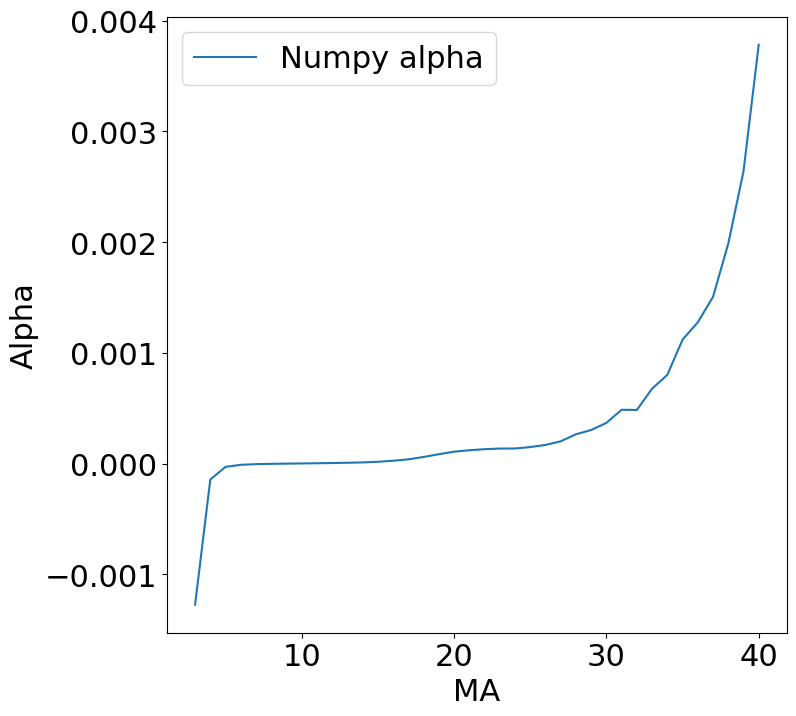

In [147]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(3,41,1), alphas, label="Numpy alpha")

plt.xlabel("MA")
plt.ylabel("Alpha")
plt.legend()

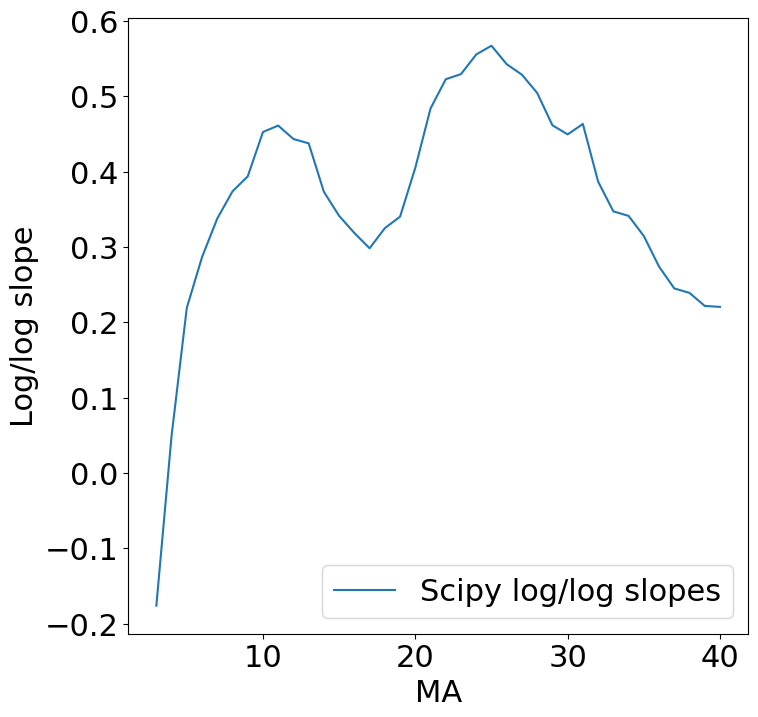

In [190]:
plt.figure(figsize=(8,8))

plt.plot(np.arange(3,41,1), loglog_slopes, label="Scipy log/log slopes")

plt.xlabel("MA")
plt.ylabel("Log/log slope")
plt.legend()